In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../playwright/results/core-web-vitals/testrun-8/'

def graph_row(plot_func, datasets, height=3, width=20):
    cols = len(datasets)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, (name, dataset) in enumerate(datasets.items()):
        plot_func(dataset, axes[x], idx=x)
        axes[x].set_title(name)
    return plt

def detect_outliers(_df, _features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(_df[_features])
    return outliers == 1


features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config','nf:loaded']
target_features = ['ttfb', 'lcp', 'tbt',  'tti', 'longestTask', 'nf:init', 'nf:loaded']

In [2]:
dirty_dfs = {
    'default': pd.read_csv(f'{path}2024-12-15T22:05:17.080Z_results-ssrh.csv', sep=',')[5:],
    'throttled': pd.read_csv(f'{path}2024-12-15T23:30:49.336Z_results-ssrh-throttled.csv', sep=',')[5:],
    'heavy': pd.read_csv(f'{path}2024-12-16T07:53:32.348Z_results-ssrh-throttled-heavy.csv', sep=',')[5:],
}

masks = {}
dfs = {}
for name, _df in dirty_dfs.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs[name] = _df[mask].copy()

In [3]:
dirty_dfs_sd = {
    'default': pd.read_csv(f'{path}2024-12-17T11:09:51.655Z_results-ssrh-sd.csv', sep=',')[5:],
    'throttled': pd.read_csv(f'{path}2024-12-17T12:56:03.620Z_results-ssrh-sd-throttled.csv', sep=',')[5:],
    'heavy': pd.read_csv(f'{path}2024-12-16T21:24:01.210Z_results-csr-sd-throttled-heavy.csv', sep=',')[5:],
}

masks = {}
dfs_sd = {}
for name, _df in dirty_dfs_sd.items():
    mask = detect_outliers(_df, target_features)
    masks[name] = mask
    dfs_sd[name] = _df[mask].copy()

/var/folders/n3/c303nvyx3yv3x75n2g2xfh1h0000gn/T/ipykernel_10997/2111309075.py:13: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[y, x].set_ylim(0, max_height * 1.2)


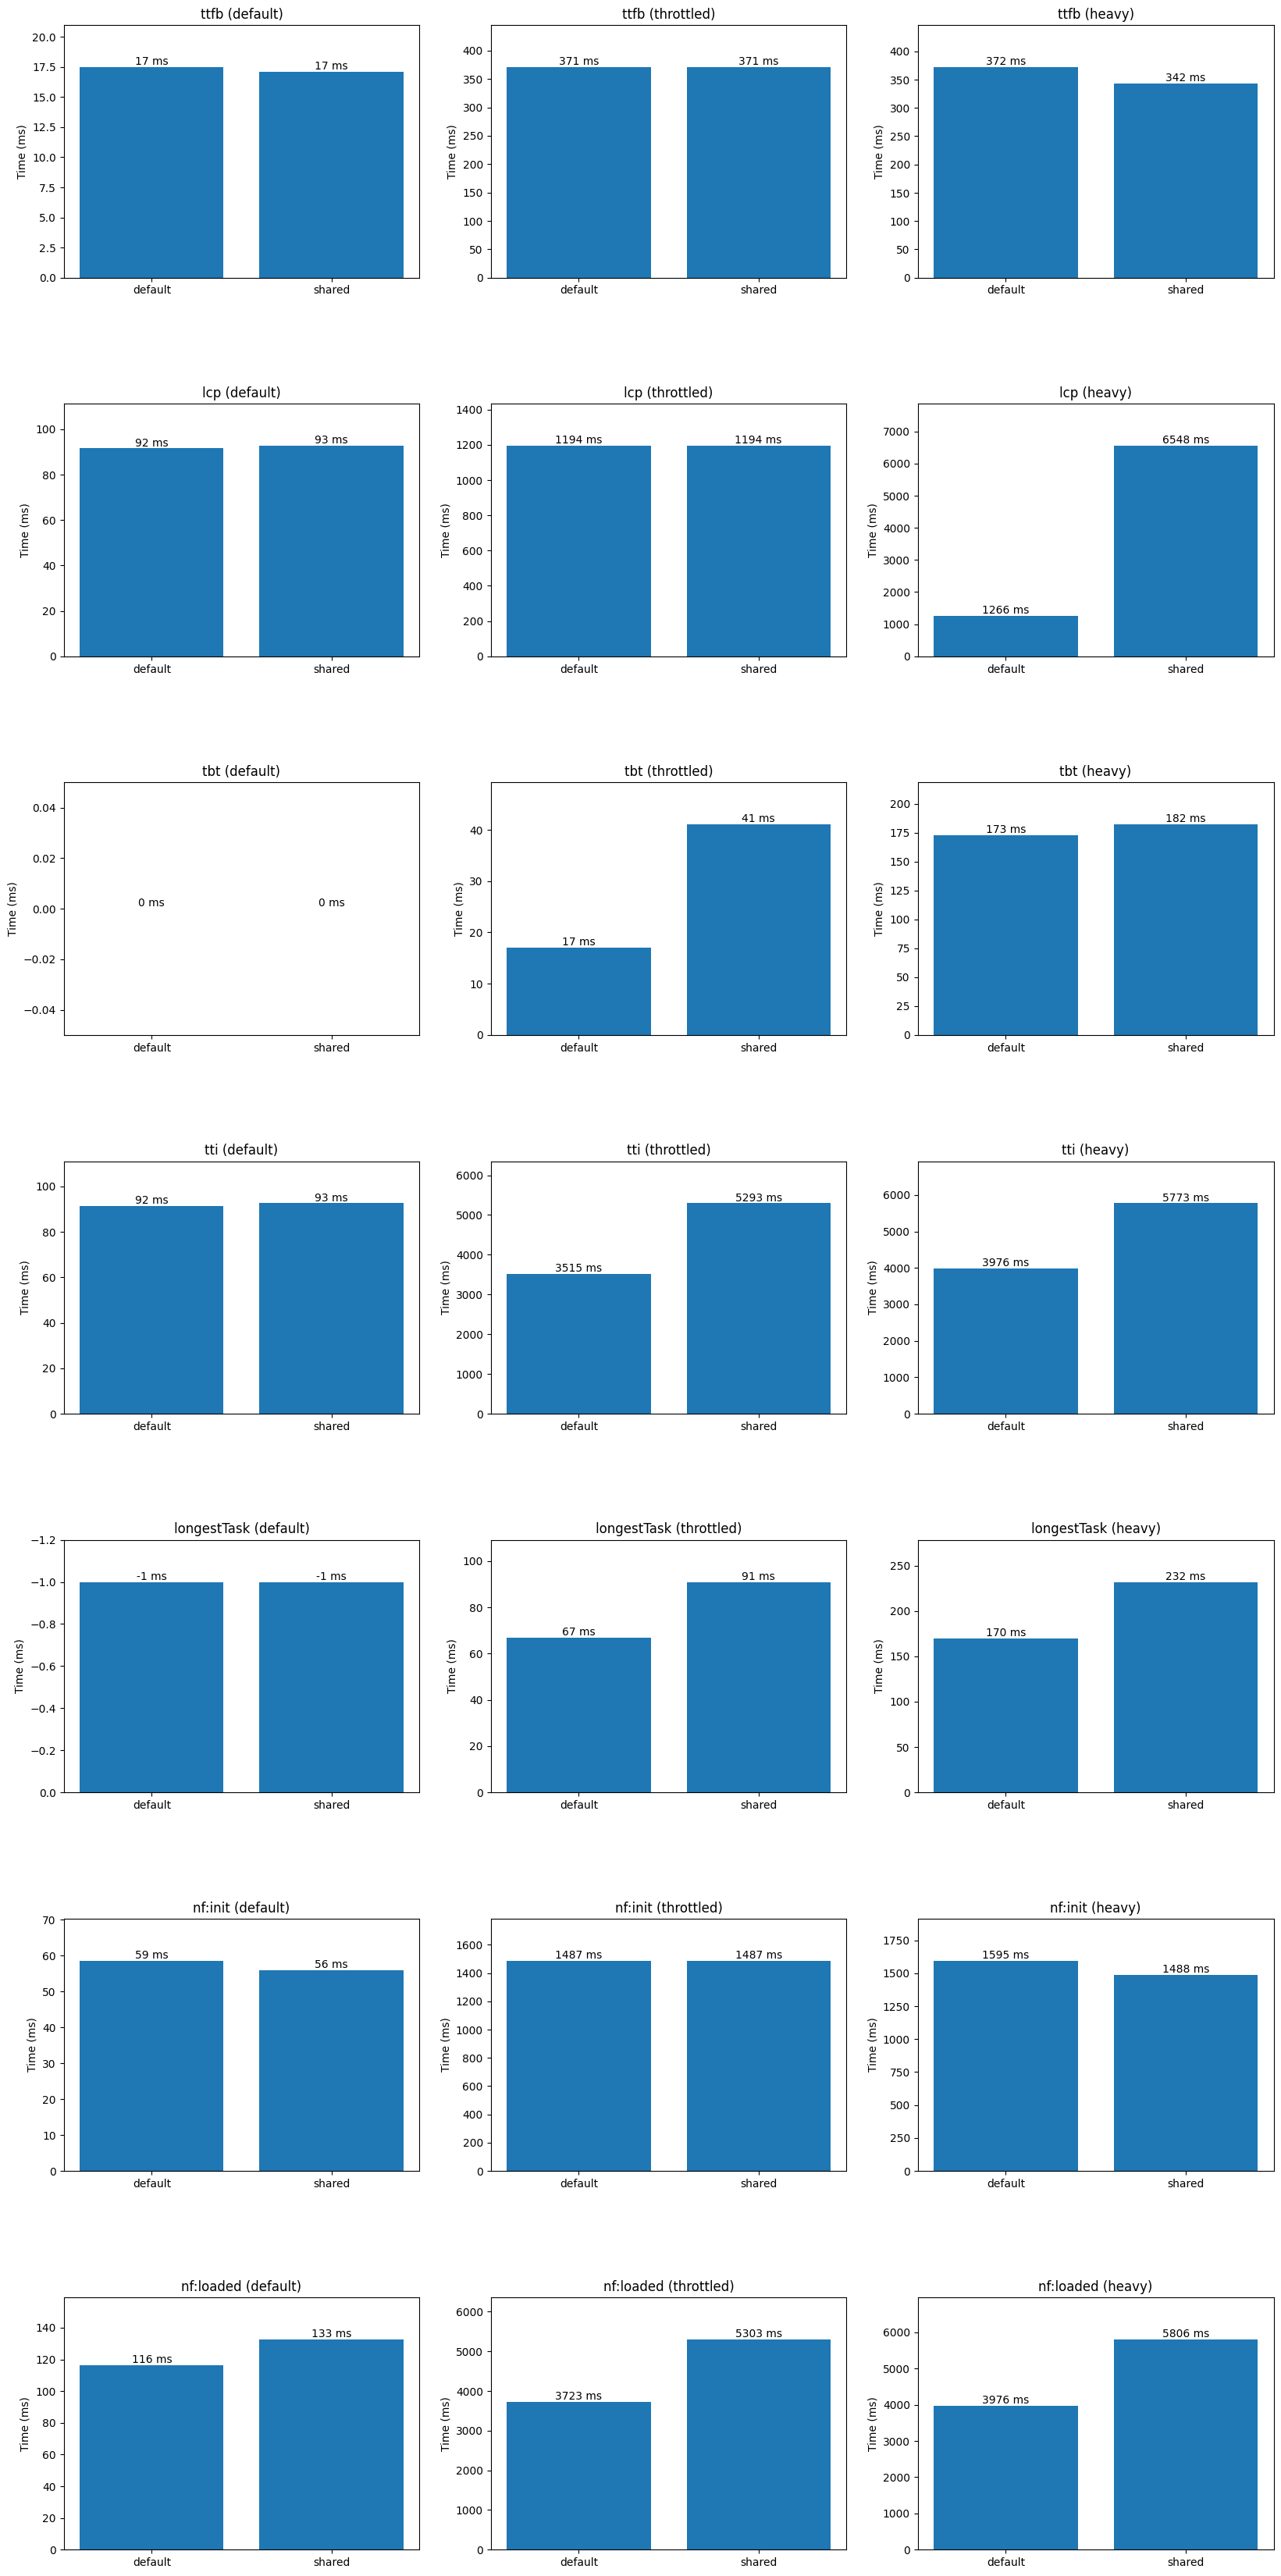

In [5]:
fig, axes = plt.subplots(nrows=len(target_features), ncols=len(dfs.keys()), figsize=(20, 6*len(target_features)))
plt.subplots_adjust(hspace=0.5)

for y, f in enumerate(target_features):
    for x, d in enumerate(dfs.keys()):
        percentiles = {
            'default': dfs[d][f].quantile(0.75),
            'shared': dfs_sd[d][f].quantile(0.75),
        }
        bars = axes[y, x].bar(percentiles.keys(), percentiles.values())
        
        max_height = max(percentiles.values())
        axes[y, x].set_ylim(0, max_height * 1.2)
        
        for i, bar in enumerate(bars):
            height = bar.get_height()
            label = f'{int(round(height, 0))} ms'
            axes[y, x].text(bar.get_x() + bar.get_width()/2., height, label, ha='center', va='bottom')
        
        axes[y, x].set_title(f'{f} ({d})')
        axes[y, x].set_ylabel('Time (ms)')

plt.show()